In [352]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator

import scipy.stats

from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [353]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

Configure plot style

In [436]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## Declarations and definitions

In [437]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [438]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [439]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [440]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})
    # add columns
    groups['% of cohort'] = 100.0*groups['count']/all_count
    groups['% of selected'] = 100.0*groups['count']/selected_count
    groups['% of patients'] = 100.0*groups['count']/stats['count']
    groups['IR'] = groups['75%'] - groups['25%']

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    results_summary = {
        'cohort': all_count,
        #'count': stats['count'],
        '% of cohort': ret['% of cohort'],
        'median': stats['median'],
        'Dxy': dxy,
        'Dxy_low': ci_low,
        'Dxy_high': ci_high,
    }
        
    return ret, groups, dff, results_summary

In [441]:
def plot_survival_function(params, dff, condition_names=None, plot_basename=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    plot_path : str | pathlib.Path
        Where to save the plot
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    
    if plot_basename is None:
        if 'risk_column_name' in params and '/' not in params['risk_column_name']:
            plot_basename = params['risk_column_name']
    
    if plot_basename is not None:
        plt.savefig(f"{plot_basename}.svg")
        plt.savefig(f"{plot_basename}.pdf")
        print(f"Saved survival function plot to '{plot_basename}.svg' and *.pdf", file=sys.stderr)
        
    plt.show()
    plt.clf()

In [442]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [443]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [444]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [445]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

Helper functions (specific to notebook(s))

In [446]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [447]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [448]:
#df = read_df(DATA_PREFIX + "cve_survival_input_df")
df = read_df(DATA_PREFIX + "cve_survival_input_most_used_language_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_most_used_language_df'...
97747 elems
97747 width duplicates dropped


In [449]:
df.head()

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,LatestCommitDate,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,2020-10-30 00:34:41+00:00,66,1621,655,2,5233,64451,59744,1,<NA>
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,2021-07-05 09:53:03+00:00,54,2498,776,60,17607,433579,136904,93,123
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,2019-11-13 00:24:16+00:00,37,1721,691,3,5964,72923,65607,2,1
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,2019-05-22 16:39:21+00:00,38,1277,536,1,3940,66416,61845,0,<NA>
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,2021-07-11 12:23:58+00:00,75,1946,723,1,13242,68725,61715,0,<NA>


### Check CVSS Rating computation

In [450]:
def f_map_cvss31(x):
    try:
        a = int(x['cvss'])
        if a < 0.1:
            return 0
        if a >= 0.1 and a <4:
            return 1
        if a >= 4 and a < 7:
            return 2
        if a >= 7 and a < 9:
            return 3
        if 9 >= a and a <= 10:
            return 4
        else:
            return None
    except:
        return None

### Exploration

In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97747 entries, 0 to 97746
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   commits                               97747 non-null  int64              
 1   commit_cves                           97747 non-null  object             
 2   project_names                         97747 non-null  object             
 3   used_dep_manager                      97747 non-null  int64              
 4   cve_lifespan_commiter_time            97747 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time              97747 non-null  timedelta64[ns]    
 6   embargo_min                           97747 non-null  bool               
 7   embargo_max                           97747 non-null  bool               
 8   lang_Shell                            97747 non-null  float64            
 9   other_languages  

In [452]:
cve_columns=[
    'cve','cvss','cwe','cvss-vector',
    'access.authentication','access.complexity','access.vector',
    'impact.availability', 'impact.confidentiality', 'impact.integrity',
    'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings',
]

In [453]:
df[cve_columns].dtypes

cve                         object
cvss                       Float64
cwe                         string
cvss-vector                 string
access.authentication     category
access.complexity         category
access.vector             category
impact.availability       category
impact.confidentiality    category
impact.integrity          category
CVSS v2.0 Ratings         category
CVSS v3.1 Ratings         category
dtype: object

In [454]:
cve_columns_categorical = cve_columns[4:]
df[cve_columns_categorical].dtypes

access.authentication     category
access.complexity         category
access.vector             category
impact.availability       category
impact.confidentiality    category
impact.integrity          category
CVSS v2.0 Ratings         category
CVSS v3.1 Ratings         category
dtype: object

In [455]:
df[cve_columns].describe()

,cvss
count,97408.000000
mean,5.905945
std,1.913505
min,0.000000
25%,4.600000
50%,5.600000
75%,7.500000
max,10.000000


In [456]:
cve_columns_numeric='cvss'

In [457]:
for column in cve_columns_categorical:
    display(df[column].value_counts().sort_index())

NONE        90667
SINGLE       6720
MULTIPLE       21
Name: access.authentication, dtype: int64

LOW       57500
MEDIUM    35723
HIGH       4185
Name: access.complexity, dtype: int64

LOCAL               23603
ADJACENT_NETWORK     2178
NETWORK             71627
Name: access.vector, dtype: int64

NONE        21367
PARTIAL     48735
COMPLETE    27306
Name: impact.availability, dtype: int64

NONE        36180
PARTIAL     42598
COMPLETE    18630
Name: impact.confidentiality, dtype: int64

NONE        39832
PARTIAL     39769
COMPLETE    17807
Name: impact.integrity, dtype: int64

Low        8989
Medium    56410
High      32009
Name: CVSS v2.0 Ratings, dtype: int64

None            6
Low          8983
Medium      56410
High        23788
Critical     8221
Name: CVSS v3.1 Ratings, dtype: int64

### Adding survival analysis-related columns

In [458]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [459]:
df[['Y','E']].describe()

,Y
count,97747.000000
mean,569.044810
std,1065.012619
min,0.000000
25%,17.000000
50%,142.000000
75%,565.000000
max,8019.000000


### Filtering

Limit to lifetime $\le$ 365 days

In [460]:
df_full=df.copy() # original unfiltered version
df=df[df['Y'] <= 365]

In [461]:
df_full[['Y','E']].describe()

,Y
count,97747.000000
mean,569.044810
std,1065.012619
min,0.000000
25%,17.000000
50%,142.000000
75%,565.000000
max,8019.000000


In [462]:
df[['Y','E']].describe()

,Y
count,62866.000000
mean,79.680225
std,97.347788
min,0.000000
25%,6.000000
50%,34.000000
75%,124.000000
max,365.000000


Checking embargo-related columns

In [463]:
True < False

False

In [464]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    62866
dtype: int64

## Analysis

In [465]:
cve_columns

['cve',
 'cvss',
 'cwe',
 'cvss-vector',
 'access.authentication',
 'access.complexity',
 'access.vector',
 'impact.availability',
 'impact.confidentiality',
 'impact.integrity',
 'CVSS v2.0 Ratings',
 'CVSS v3.1 Ratings']

CVE columns to analyze
- CVSS (Common Vulnerability Scoring System)
    - [x] CVSS
    - [x] CVSS v2.0 Ratings
    - [x] CVSS v3.1 Ratings
- access.\*
    - [x] access.authentication,
    - [x] access.complexity,
    - [x] access.vector,
- impact.\* (same categories) 
    - [x] impact.availability,
    - [x] impact.confidentiality,
    - [x] impact.integrity

In [466]:
results_summary={}

### CVSS

<AxesSubplot: ylabel='Count'>

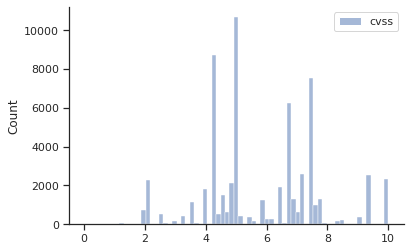

In [467]:
sns.histplot(data=df[['cvss']].dropna())

In [468]:
df[['cvss']].dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62646 entries, 43 to 97745
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cvss    62646 non-null  Float64
dtypes: Float64(1)
memory usage: 1.0 MB


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


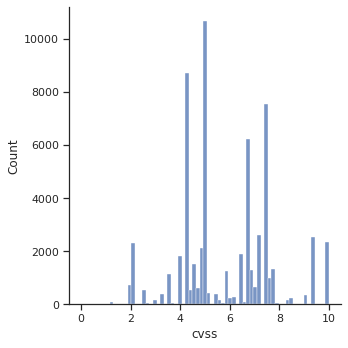

In [469]:
sns.displot(df,x='cvss')

<AxesSubplot: ylabel='Density'>

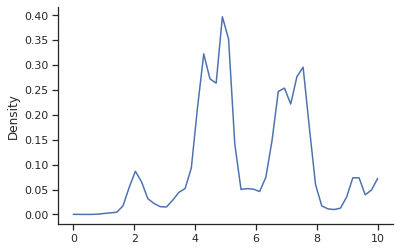

In [470]:
df['cvss'].dropna().plot.kde(ind=np.linspace(0,10))

<AxesSubplot: xlabel='cvss', ylabel='Y'>

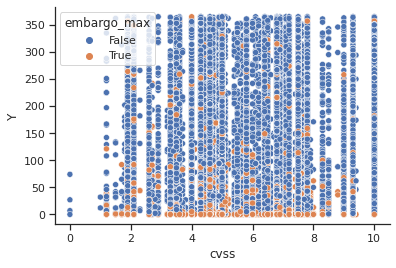

In [471]:
sns.scatterplot(data=df, x='cvss', y='Y', hue='embargo_max')

#### CVSS v2.0 Ratings

In [472]:
cve_columns_categorical

['access.authentication',
 'access.complexity',
 'access.vector',
 'impact.availability',
 'impact.confidentiality',
 'impact.integrity',
 'CVSS v2.0 Ratings',
 'CVSS v3.1 Ratings']

In [473]:
column_name='CVSS v2.0 Ratings'
column_cut=column_name

CVSS v2.0 Ratings
Low        5569
Medium    38315
High      18762
dtype: int64

<AxesSubplot: xlabel='CVSS v2.0 Ratings', ylabel='CVE+project'>

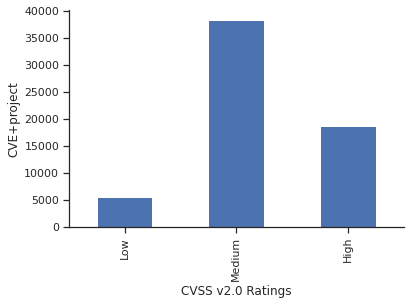

In [474]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [475]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: 'Low', 1: 'Medium', 2: 'High'}

In [476]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, results_summary[column_cut]) = \
    apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.022273180580934304,
    "bootstrap": {
        "Dxy": -0.021965530121804508,
        "Confidence interval low": -0.0226074376327299,
        "Confidence interval high": -0.021323622610879115,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CVSS v2.0 Ratings,,,,,,,,,,,,,
Low,5569,51.0,0,10.0,155.0,365,93.831747,101.911603,1.029089,8.858524,8.889634,8.889634,145.0
Medium,38315,34.0,0,6.0,121.0,365,78.674514,96.705555,1.329246,60.947094,61.161128,61.161128,115.0
High,18762,31.0,0,5.0,119.0,365,77.732758,97.003705,1.324748,29.844431,29.949239,29.949239,114.0


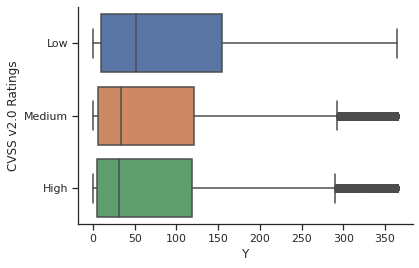

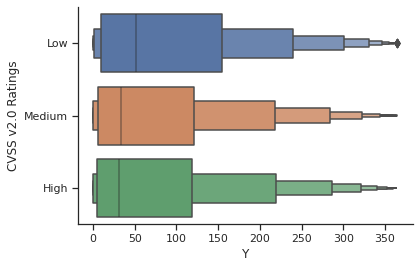

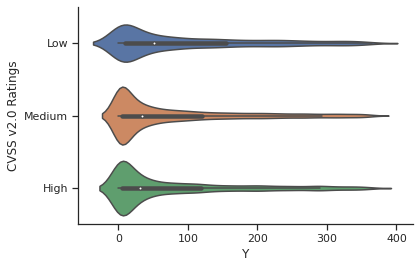

In [477]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'CVSS v2.0 Ratings.svg' and *.pdf


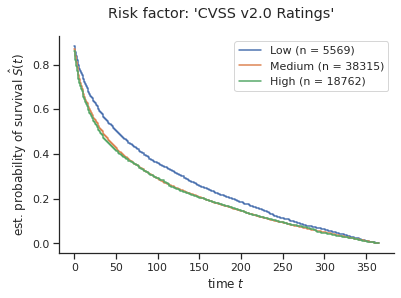

<Figure size 432x288 with 0 Axes>

In [478]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

#### CVSS v3.1 Ratings

In [479]:
column_name='CVSS v3.1 Ratings'
column_cut=column_name

CVSS v3.1 Ratings
None            4
Low          5565
Medium      38315
High        13542
Critical     5220
dtype: int64

<AxesSubplot: xlabel='CVSS v3.1 Ratings', ylabel='CVE+project'>

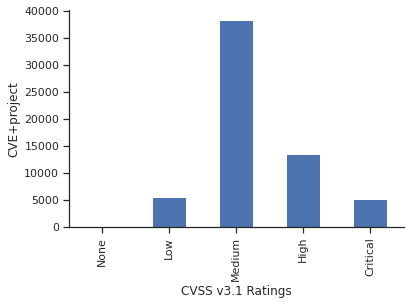

In [480]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [481]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.027289400247853535,
    "bootstrap": {
        "Dxy": -0.027876110256138613,
        "Confidence interval low": -0.028570526257549526,
        "Confidence interval high": -0.0271816942547277,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CVSS v3.1 Ratings,,,,,,,,,,,,,
None,4,17.0,0,5.25,38.75,74,27.000000,33.356659,1.367647,0.006363,0.006385,0.006385,33.5
Low,5565,51.0,0,10.00,155.00,365,93.879784,101.929525,1.028175,8.852162,8.883249,8.883249,145.0
Medium,38315,34.0,0,6.00,121.00,365,78.674514,96.705555,1.329246,60.947094,61.161128,61.161128,115.0
High,13542,35.0,0,6.00,130.00,365,82.608551,98.925658,1.236692,21.541056,21.616703,21.616703,124.0
Critical,5220,21.0,0,2.00,92.00,365,65.083716,90.624400,1.589232,8.303375,8.332535,8.332535,90.0


In [482]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

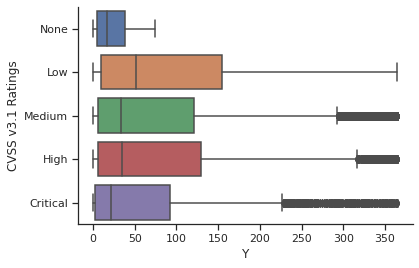

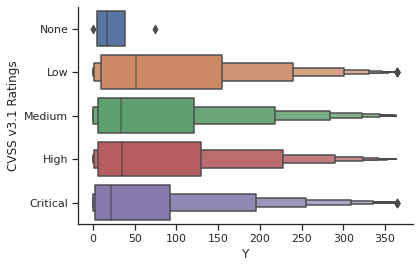

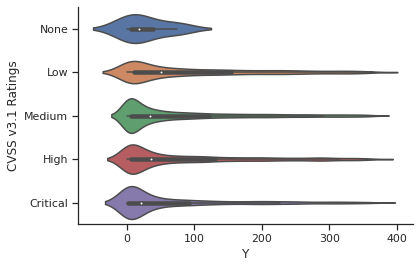

In [483]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'CVSS v3.1 Ratings.svg' and *.pdf


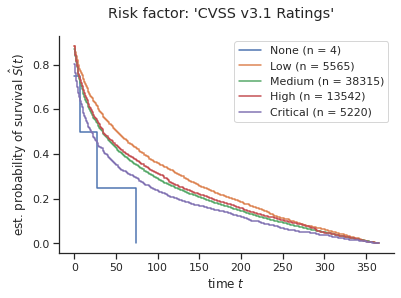

<Figure size 432x288 with 0 Axes>

In [484]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [485]:
print(values_names)
if 0 in values_names:
    del values_names[0]
if 'None' in values_hash:
    del values_hash['None']
print(values_names)

{0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}
{1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}


In [486]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62642, uncensored = 62642
Computing 50 × bootstrap Dxy for 62642 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62642.0,
    "% of cohort": 99.64368657143766,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.02732966709699136,
    "bootstrap": {
        "Dxy": -0.02752253257707395,
        "Confidence interval low": -0.02822410453709451,
        "Confidence interval high": -0.02682096061705339,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CVSS v3.1 Ratings,,,,,,,,,,,,,
Low,5565,51.0,0,10.0,155.0,365,93.879784,101.929525,1.028175,8.852162,8.883816,8.883816,145.0
Medium,38315,34.0,0,6.0,121.0,365,78.674514,96.705555,1.329246,60.947094,61.165033,61.165033,115.0
High,13542,35.0,0,6.0,130.0,365,82.608551,98.925658,1.236692,21.541056,21.618084,21.618084,124.0
Critical,5220,21.0,0,2.0,92.0,365,65.083716,90.624400,1.589232,8.303375,8.333067,8.333067,90.0


In [487]:
results_summary[column_cut+' no None'] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

values_list = dict_keys([1, 2, 3, 4])


Saved survival function plot to 'CVSS v3.1 Ratings no None.svg' and *.pdf


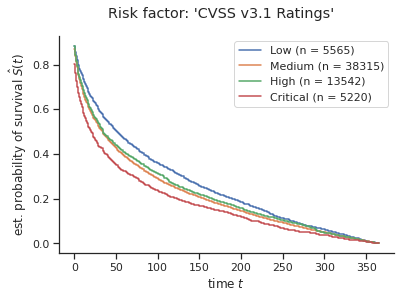

<Figure size 432x288 with 0 Axes>

In [488]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names, plot_basename=column_cut+' no None')

In [489]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(ranking_list)
print(values_hash)
print(values_names)
print("------------------------------------------")

values_hash['None'] = 1
values_names[1] = 'None+Low'
del values_names[0]

print(values_hash)
print(values_names)

['None', 'Low', 'Medium', 'High', 'Critical']
{'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4}
{0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Critical'}
------------------------------------------
{'None': 1, 'Low': 1, 'Medium': 2, 'High': 3, 'Critical': 4}
{1: 'None+Low', 2: 'Medium', 3: 'High', 4: 'Critical'}


In [490]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, results_summary[column_cut+" 4bin"]) = \
    apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
print(f"{column_cut} 4bin:")
display(groups)
#print(results_summary[f"{column_cut} 4bin"])

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.027293837125601406,
    "bootstrap": {
        "Dxy": -0.02688931021934675,
        "Confidence interval low": -0.027699914543807592,
        "Confidence interval high": -0.026078705894885906,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}
CVSS v3.1 Ratings 4bin:


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
CVSS v3.1 Ratings,,,,,,,,,,,,,
None+Low,5569,51.0,0,10.0,155.0,365,93.831747,101.911603,1.029089,8.858524,8.889634,8.889634,145.0
Medium,38315,34.0,0,6.0,121.0,365,78.674514,96.705555,1.329246,60.947094,61.161128,61.161128,115.0
High,13542,35.0,0,6.0,130.0,365,82.608551,98.925658,1.236692,21.541056,21.616703,21.616703,124.0
Critical,5220,21.0,0,2.0,92.0,365,65.083716,90.624400,1.589232,8.303375,8.332535,8.332535,90.0


In [491]:
ddf['agg'].value_counts().sort_index()

1.0     5569
2.0    38315
3.0    13542
4.0     5220
Name: agg, dtype: int64

values_list = dict_keys([1, 2, 3, 4])


Saved survival function plot to 'CVSS v3.1 Ratings 4bin.svg' and *.pdf


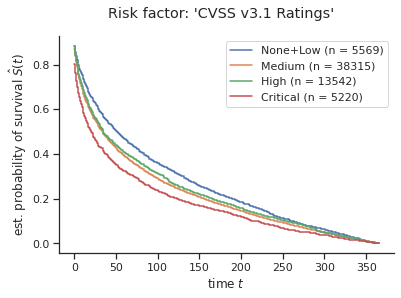

<Figure size 432x288 with 0 Axes>

In [492]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names, plot_basename=f"{column_cut} 4bin")

### access.*

#### access.vector

In [493]:
column_name='access.vector'
column_cut=column_name
df[column_name].head()

43                LOCAL
135    ADJACENT_NETWORK
141               LOCAL
142               LOCAL
143               LOCAL
Name: access.vector, dtype: category
Categories (3, object): ['LOCAL' < 'ADJACENT_NETWORK' < 'NETWORK']

access.vector
LOCAL               12897
ADJACENT_NETWORK     1108
NETWORK             48641
dtype: int64

<AxesSubplot: xlabel='access.vector', ylabel='CVE+project'>

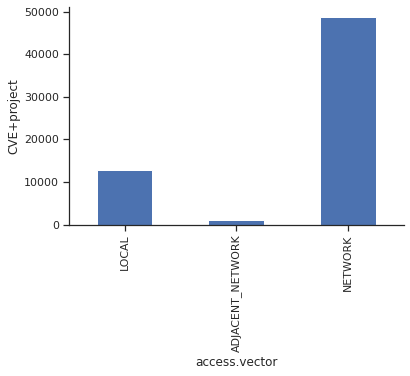

In [494]:
display(df.value_counts(column_cut).sort_index())

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [495]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: 'LOCAL', 1: 'ADJACENT_NETWORK', 2: 'NETWORK'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.070739298779252,
    "bootstrap": {
        "Dxy": -0.07070633941849963,
        "Confidence interval low": -0.07127591881974334,
        "Confidence interval high": -0.07013676001725593,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
access.vector,,,,,,,,,,,,,
LOCAL,12897,67.0,0,14.0,182.0,365,106.444832,106.193481,0.826797,20.515064,20.587109,20.587109,168.0
ADJACENT_NETWORK,1108,35.0,0,5.0,135.0,365,82.707581,97.537972,1.222335,1.762479,1.768668,1.768668,130.0
NETWORK,48641,28.0,0,4.0,107.0,365,72.591559,93.612581,1.458705,77.372507,77.644223,77.644223,103.0


In [496]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

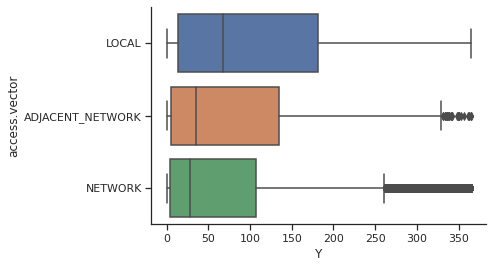

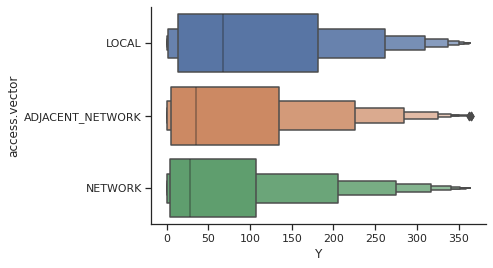

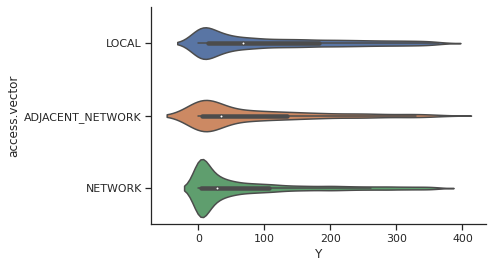

In [497]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'access.vector.svg' and *.pdf


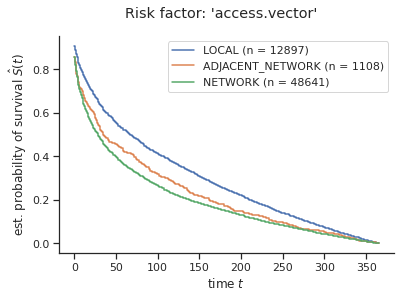

<Figure size 432x288 with 0 Axes>

In [498]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

Delete `ADJACENT_NETWORK` as underrepresented

In [499]:
print(values_names)
del values_names[1]
del values_hash['ADJACENT_NETWORK']
print(values_names)

{0: 'LOCAL', 1: 'ADJACENT_NETWORK', 2: 'NETWORK'}
{0: 'LOCAL', 2: 'NETWORK'}


In [500]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 61538, uncensored = 61538
Computing 50 × bootstrap Dxy for 61538 elements...


{
    "Cohort": 62866,
    "Number of patients": 61538.0,
    "% of cohort": 97.88757038780899,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.07049508638720392,
    "bootstrap": {
        "Dxy": -0.07054600332923343,
        "Confidence interval low": -0.07104045430185224,
        "Confidence interval high": -0.07005155235661462,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
access.vector,,,,,,,,,,,,,
LOCAL,12897,67.0,0,14.0,182.0,365,106.444832,106.193481,0.826797,20.515064,20.957782,20.957782,168.0
NETWORK,48641,28.0,0,4.0,107.0,365,72.591559,93.612581,1.458705,77.372507,79.042218,79.042218,103.0


In [501]:
results_summary[column_cut+' no ADJACENT_NETWORK'] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

values_list = dict_keys([0, 2])


Saved survival function plot to 'access.vector no ADJACENT_NETWORK.svg' and *.pdf


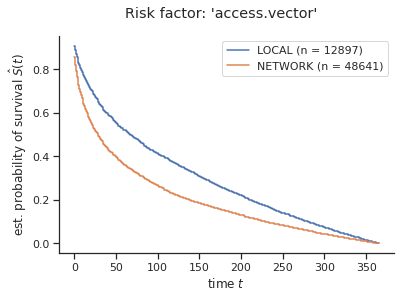

<Figure size 432x288 with 0 Axes>

In [502]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names, plot_basename=column_cut+' no ADJACENT_NETWORK')

#### access.complexity

access.complexity


access.complexity
LOW       35933
MEDIUM    24081
HIGH       2632
dtype: int64

<AxesSubplot: xlabel='access.complexity', ylabel='CVE+project'>

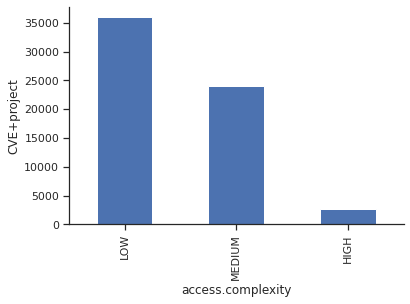

{0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.03597618153946114,
    "bootstrap": {
        "Dxy": -0.03594270172842525,
        "Confidence interval low": -0.03664161218426335,
        "Confidence interval high": -0.03524379127258715,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
access.complexity,,,,,,,,,,,,,
LOW,35933,39.0,0,6.0,132.0,365,83.970501,99.173310,1.217872,57.158082,57.358810,57.358810,126.0
MEDIUM,24081,31.0,0,5.0,117.0,365,75.475852,95.492401,1.392458,38.305284,38.439805,38.439805,112.0
HIGH,2632,18.5,0,2.0,91.0,365,60.995061,84.780435,1.611387,4.186683,4.201386,4.201386,89.0


<AxesSubplot: xlabel='Y', ylabel='access.complexity'>

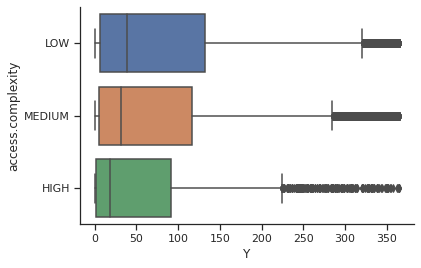

<AxesSubplot: xlabel='Y', ylabel='access.complexity'>

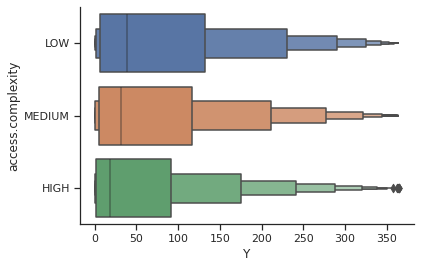

<AxesSubplot: xlabel='Y', ylabel='access.complexity'>

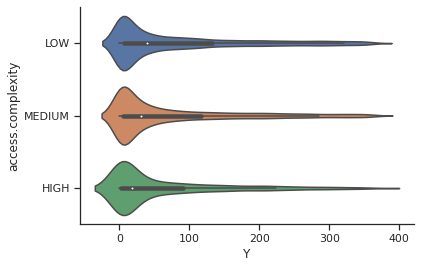

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'access.complexity.svg' and *.pdf


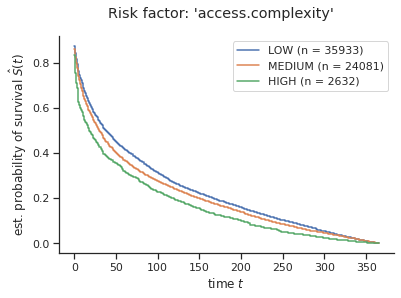

<Figure size 432x288 with 0 Axes>

In [503]:
column_name='access.complexity'
column_cut=column_name
print(column_cut)

display(df.value_counts(column_cut).sort_index())
df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

## MAIN COMPUTATIONS ##
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

## SAVE ##
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

## PLOTS ##
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

plot_survival_function(params, ddf, condition_names=values_names)

#### access.authentication

access.authentication


access.authentication
NONE        57560
SINGLE       5065
MULTIPLE       21
dtype: int64

<AxesSubplot: xlabel='access.authentication', ylabel='CVE+project'>

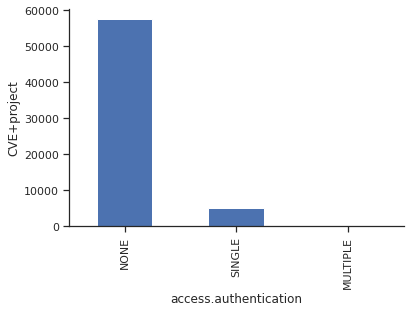

{0: 'NONE', 1: 'SINGLE', 2: 'MULTIPLE'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.017503287492822595,
    "bootstrap": {
        "Dxy": -0.017461517664972045,
        "Confidence interval low": -0.017820491124403207,
        "Confidence interval high": -0.017102544205540884,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
access.authentication,,,,,,,,,,,,,
NONE,57560,35.0,0,6.0,129.0,365,81.451598,98.283091,1.260795,91.559826,91.881365,91.881365,123.0
SINGLE,5065,22.0,0,4.0,85.0,364,60.405331,83.967588,1.802630,8.056819,8.085113,8.085113,81.0
MULTIPLE,21,20.0,2,14.0,54.0,313,51.333333,78.417685,2.559406,0.033404,0.033522,0.033522,40.0


<AxesSubplot: xlabel='Y', ylabel='access.authentication'>

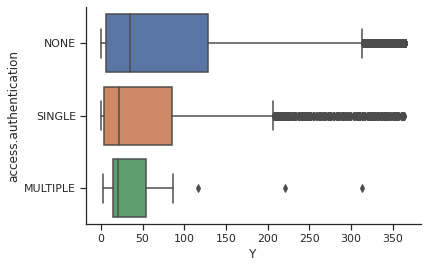

<AxesSubplot: xlabel='Y', ylabel='access.authentication'>

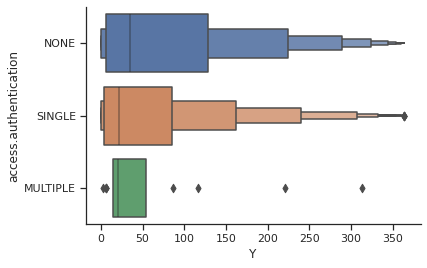

<AxesSubplot: xlabel='Y', ylabel='access.authentication'>

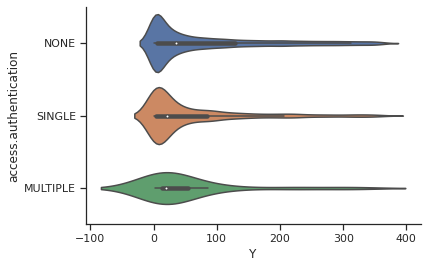

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'access.authentication.svg' and *.pdf


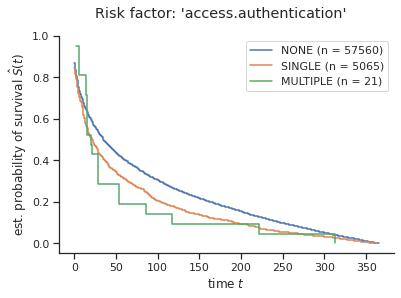

<Figure size 432x288 with 0 Axes>

In [504]:
column_name='access.authentication'
column_cut=column_name
print(column_cut)

display(df.value_counts(column_cut).sort_index())
df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

## MAIN COMPUTATIONS ##
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

## SAVE ##
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

## PLOTS ##
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

plot_survival_function(params, ddf, condition_names=values_names)

-----
Without `MULTIPLE`, as it is underrepresented class

In [505]:
print(values_names)
del values_names[2]
del values_hash['MULTIPLE']
print(values_names)

{0: 'NONE', 1: 'SINGLE', 2: 'MULTIPLE'}
{0: 'NONE', 1: 'SINGLE'}


In [506]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62625, uncensored = 62625
Computing 50 × bootstrap Dxy for 62625 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62625.0,
    "% of cohort": 99.6166449273057,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.01746742977749116,
    "bootstrap": {
        "Dxy": -0.017507259252549298,
        "Confidence interval low": -0.017912147441012605,
        "Confidence interval high": -0.01710237106408599,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
access.authentication,,,,,,,,,,,,,
NONE,57560,35.0,0,6.0,129.0,365,81.451598,98.283091,1.260795,91.559826,91.912176,91.912176,123.0
SINGLE,5065,22.0,0,4.0,85.0,364,60.405331,83.967588,1.802630,8.056819,8.087824,8.087824,81.0


In [507]:
results_summary[column_cut+' no MULTIPLE'] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

values_list = dict_keys([0, 1])


Saved survival function plot to 'access.authentication no MULTIPLE.svg' and *.pdf


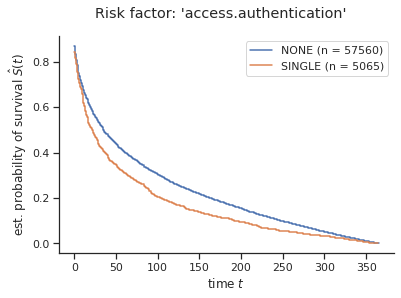

<Figure size 432x288 with 0 Axes>

In [508]:
plot_survival_function(params, ddf, condition_names=values_names, plot_basename=column_cut+' no MULTIPLE')

### impact.*

#### impact.availability

impact.availability


impact.availability
NONE        14991
PARTIAL     32005
COMPLETE    15650
dtype: int64

<AxesSubplot: xlabel='impact.availability', ylabel='CVE+project'>

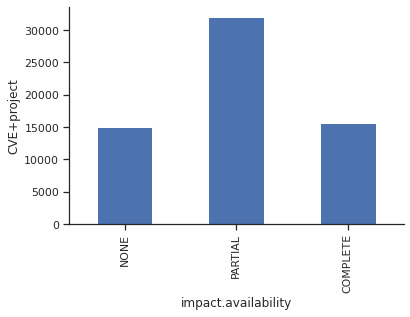

{0: 'NONE', 1: 'PARTIAL', 2: 'COMPLETE'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.022437447366787433,
    "bootstrap": {
        "Dxy": 0.021641677778243898,
        "Confidence interval low": 0.020888041241371266,
        "Confidence interval high": 0.02239531431511653,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
impact.availability,,,,,,,,,,,,,
NONE,14991,30.0,0,4.0,118.0,365,75.625309,95.998127,1.371384,23.845958,23.929700,23.929700,114.0
PARTIAL,32005,35.0,0,6.0,119.0,365,78.695298,96.054793,1.339804,50.909872,51.088657,51.088657,113.0
COMPLETE,15650,37.0,0,6.0,143.0,365,85.817444,100.990714,1.153442,24.894219,24.981643,24.981643,137.0


<AxesSubplot: xlabel='Y', ylabel='impact.availability'>

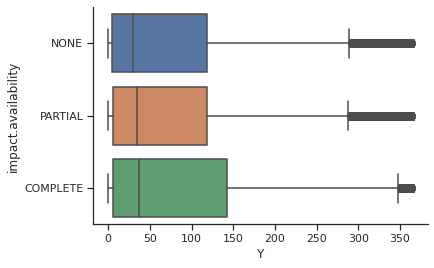

<AxesSubplot: xlabel='Y', ylabel='impact.availability'>

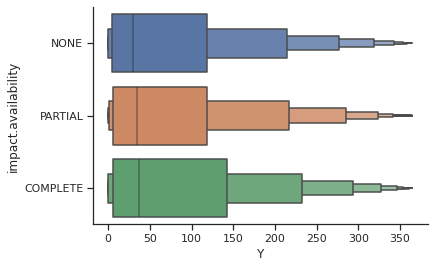

<AxesSubplot: xlabel='Y', ylabel='impact.availability'>

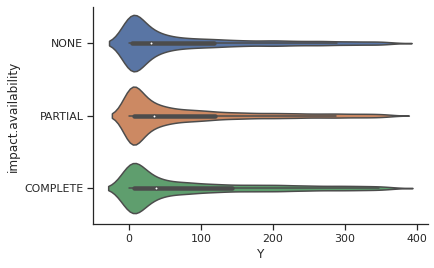

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'impact.availability.svg' and *.pdf


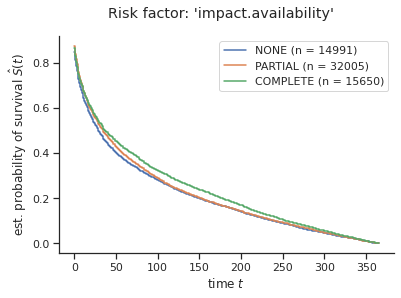

<Figure size 432x288 with 0 Axes>

In [509]:
column_name='impact.availability'
column_cut=column_name
print(column_cut)

display(df.value_counts(column_cut).sort_index())
df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

## MAIN COMPUTATIONS ##
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

## SAVE ##
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

## PLOTS ##
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

plot_survival_function(params, ddf, condition_names=values_names)

#### impact.confidentiality

impact.confidentiality


impact.confidentiality
NONE        23966
PARTIAL     27527
COMPLETE    11153
dtype: int64

<AxesSubplot: xlabel='impact.confidentiality', ylabel='CVE+project'>

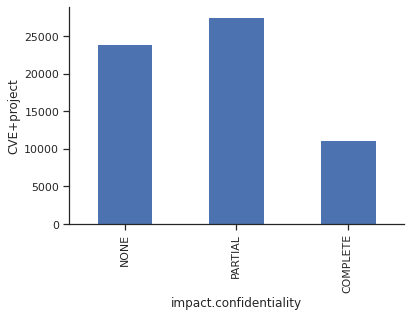

{0: 'NONE', 1: 'PARTIAL', 2: 'COMPLETE'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.023310975681907875,
    "bootstrap": {
        "Dxy": -0.02352740620714501,
        "Confidence interval low": -0.024369272351741453,
        "Confidence interval high": -0.022685540062548568,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
impact.confidentiality,,,,,,,,,,,,,
NONE,23966,39.0,0,7.0,131.0,365,83.112409,98.440244,1.253770,38.122355,38.256233,38.256233,124.0
PARTIAL,27527,31.0,0,5.0,119.0,365,77.271370,96.200049,1.345894,43.786785,43.940555,43.940555,114.0
COMPLETE,11153,31.0,0,4.0,126.0,365,78.585493,97.712090,1.280530,17.740909,17.803212,17.803212,122.0


<AxesSubplot: xlabel='Y', ylabel='impact.confidentiality'>

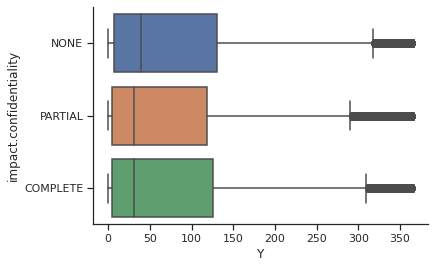

<AxesSubplot: xlabel='Y', ylabel='impact.confidentiality'>

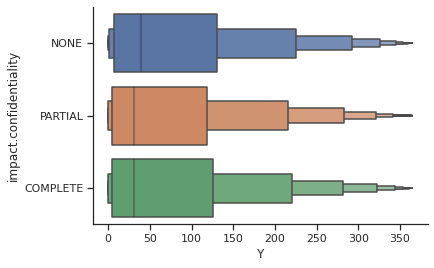

<AxesSubplot: xlabel='Y', ylabel='impact.confidentiality'>

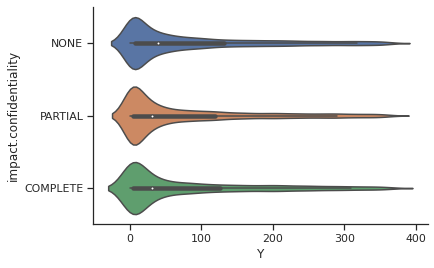

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'impact.confidentiality.svg' and *.pdf


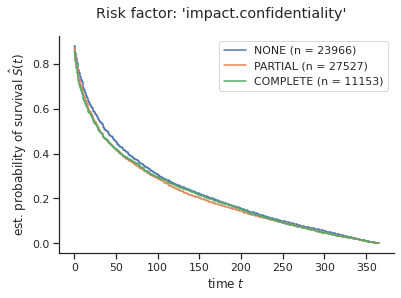

<Figure size 432x288 with 0 Axes>

In [510]:
column_name='impact.confidentiality'
column_cut=column_name
print(column_cut)

display(df.value_counts(column_cut).sort_index())
df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

## MAIN COMPUTATIONS ##
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

## SAVE ##
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

## PLOTS ##
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

plot_survival_function(params, ddf, condition_names=values_names)

#### impact.integrity

impact.integrity


impact.integrity
NONE        26236
PARTIAL     25710
COMPLETE    10700
dtype: int64

<AxesSubplot: xlabel='impact.integrity', ylabel='CVE+project'>

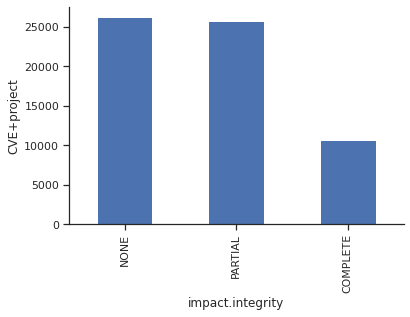

{0: 'NONE', 1: 'PARTIAL', 2: 'COMPLETE'}

all = 62866, selected = 62646, uncensored = 62646
Computing 50 × bootstrap Dxy for 62646 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62646.0,
    "% of cohort": 99.65004931123342,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.04755356519446918,
    "bootstrap": {
        "Dxy": -0.047283685701529486,
        "Confidence interval low": -0.04799566491653037,
        "Confidence interval high": -0.0465717064865286,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


,count,median,min,25%,75%,max,mean,std,skew,% of cohort,% of selected,% of patients,IR
impact.integrity,,,,,,,,,,,,,
NONE,26236,44.0,0,8.0,140.0,365,87.322763,99.706459,1.167040,41.733210,41.879769,41.879769,132.0
PARTIAL,25710,28.0,0,4.0,111.0,365,73.519642,94.884877,1.434261,40.896510,41.040130,41.040130,107.0
COMPLETE,10700,29.0,0,4.0,119.0,365,76.092991,96.184603,1.331693,17.020329,17.080101,17.080101,115.0


<AxesSubplot: xlabel='Y', ylabel='impact.integrity'>

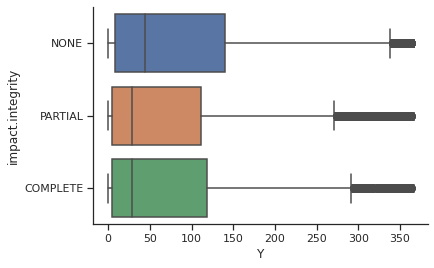

<AxesSubplot: xlabel='Y', ylabel='impact.integrity'>

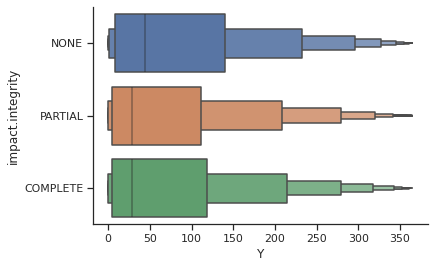

<AxesSubplot: xlabel='Y', ylabel='impact.integrity'>

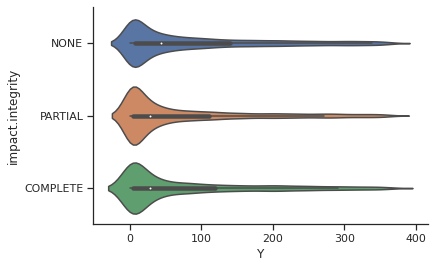

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'impact.integrity.svg' and *.pdf


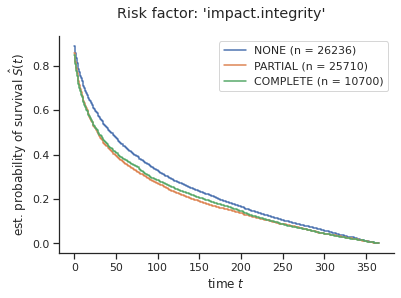

<Figure size 432x288 with 0 Axes>

In [511]:
column_name='impact.integrity'
column_cut=column_name
print(column_cut)

display(df.value_counts(column_cut).sort_index())
df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

## MAIN COMPUTATIONS ##
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf, _) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

## SAVE ##
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

## PLOTS ##
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

plot_survival_function(params, ddf, condition_names=values_names)

## Summary

In [512]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

,cohort,% of cohort,median,Dxy,Dxy_low,Dxy_high
CVSS v2.0 Ratings,62866,99.650049,34.0,-0.021966,-0.022607,-0.021324
CVSS v3.1 Ratings,62866,99.650049,34.0,-0.027876,-0.028571,-0.027182
CVSS v3.1 Ratings no None,62866,99.643687,34.0,-0.027523,-0.028224,-0.026821
CVSS v3.1 Ratings 4bin,62866,99.650049,34.0,-0.026889,-0.027700,-0.026079
access.vector,62866,99.650049,34.0,-0.070706,-0.071276,-0.070137
access.vector no ADJACENT_NETWORK,62866,97.887570,34.0,-0.070546,-0.071040,-0.070052
access.complexity,62866,99.650049,34.0,-0.035943,-0.036642,-0.035244
access.authentication,62866,99.650049,34.0,-0.017462,-0.017820,-0.017103
access.authentication no MULTIPLE,62866,99.616645,34.0,-0.017507,-0.017912,-0.017102
impact.availability,62866,99.650049,34.0,0.021642,0.020888,0.022395


<AxesSubplot: title={'center': 'Dxy'}>

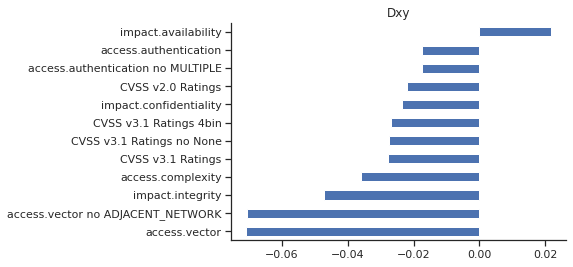

In [513]:
summary_df['Dxy'].sort_values().plot(kind='barh',title='Dxy')

<AxesSubplot: title={'center': 'Dxy'}>

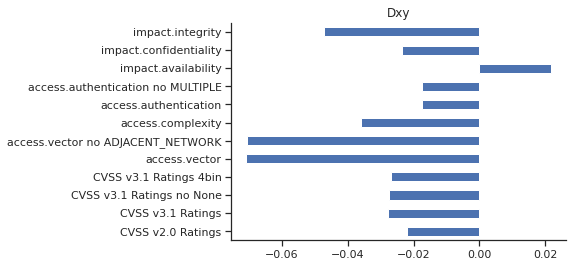

In [514]:
summary_df['Dxy'].plot(kind='barh',title='Dxy')

<AxesSubplot: title={'center': 'Dxy'}>

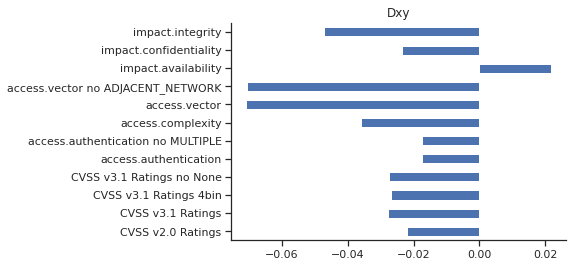

In [515]:
summary_df['Dxy'].sort_index().plot(kind='barh',title='Dxy')

In [516]:
#ver='365days'
ver='most_used_language.365days'
summary_df.to_csv(f"survey_analysis_CVE_metadata.{ver}.csv")